# 0. Prepare

In [ ]:
import zipfile
import time
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


from zipfile import ZipFile
from memory_profiler import profile

In [ ]:
url = '/Users/thienhtt20/Documents/GitHub/Handling-Data/MyData/2019-Nov.csv.zip'

In [ ]:
df = pd.read_csv(url, compression='zip', header=0, sep=',', quotechar='"', nrows=10)

In [ ]:
df.columns.tolist()

# 1.Better read file

### 1.1.Basic Feature Selection For Analysis

1. As we can see, there are 5 features we actually need to do care about:

    [**'category_code', 'brand', 'price', 'event_time', 'event_type'** ]
2. The rest would be outliers and redundant due to its data format and unreadble
3. Data records should be determined
4. Data size is enormous ~60M records --> cannot read immediately
5. Data type unoptimized (**float64 -> float16**)


In [ ]:
df.head(2)

In [ ]:
needed_categories = ['event_time', 'category_code', 'event_type', 'brand', 'price']

In [ ]:
with zipfile.ZipFile(url, 'r') as zip_file:
    file_list = zip_file.namelist()

# Assuming the zipped CSV file contains only one CSV file
csv_file_name = file_list[0]

# Specify the chunk size for reading the file
chunk_size = 1000000  # Adjust this based on your available memory

# Initialize a counter for total records
total_records = 0

# Read the zipped CSV file in chunks and count records
for chunk in pd.read_csv(url, compression='zip', header=0, sep=',', quotechar='"', chunksize=chunk_size):
    total_records += len(chunk)

print(f'Total records in the zipped CSV file: {total_records}')


### 1.2 Optimized Data Type

#### 1.2.1 FLOAT TYPE

In [ ]:
df[needed_categories].dtypes

In [ ]:
df = df[needed_categories]

In [ ]:
df['price'] = df['price'].astype('float16')

#### 1.2.2 TIME TYPE

In [ ]:
df.head(4)

In [ ]:
df['event_time'] = df['event_time'].apply(lambda x: x.split(' ')[0])

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
df['event_time'].dtypes

In [ ]:
df['event_time']

# 2. READ WITH CHUNK_SIZE

### 2.1 Chunk_size and check null

In [ ]:
df_test = pd.read_csv(url, compression='zip', header=0, sep=',', quotechar='"', chunksize=1000000)

In [ ]:
for chunk in df_test:
    chunk = chunk[needed_categories]
    print(chunk.isna().sum())
    break

### 2.2 More Details

- From 1M records with each chunk, we are able to reduce ~40% records from 1M to roughly 600K records for the **FIRST** chunk

In [ ]:
import pandas as pd

chunk_size = 1000000
df_chunks = pd.read_csv(url, compression='zip', header=0, sep=',', quotechar='"', chunksize=chunk_size)


for i, chunk in enumerate(df_chunks):
    print(f"Memory usage for chunk {i + 1}: {chunk.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")



In [ ]:
df_chunks = pd.read_csv(url, compression='zip', header=0, 
                 sep=',', quotechar='"',
                 usecols=needed_categories, chunksize=1000000)
for i, chunk in enumerate(df_chunks):
    print(f"Memory usage for chunk {i + 1}: {chunk.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")


In [ ]:
def process_data(url, chunk_size, needed_categories):
    start_time = time.time()
    df_chunks = pd.read_csv(url, compression='zip', header=0, 
                 sep=',', quotechar='"',
                 usecols=needed_categories, chunksize=chunk_size)
    large = []
    small = []
    final_output = pd.DataFrame()
    
    for i, chunk in enumerate(df_chunks):
        print(f"Memory usage for chunk {i}: {chunk.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
        large.append(chunk.memory_usage(deep=True).sum() / (1024 ** 2))

        chunk['count'] = np.int32(1)
        chunk['event_time'] = pd.to_datetime(chunk['event_time']).dt.date
        processed_chunk = chunk.groupby(needed_categories, as_index=False).sum().reset_index(drop=True)
        processed_chunk['price'] = processed_chunk['price'].astype('float16')
        final_output = pd.concat([final_output, processed_chunk], ignore_index=True, sort=False)
        
        print(f"Memory usage after processing chunk {i}: {processed_chunk.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
        small.append(processed_chunk.memory_usage(deep=True).sum() / (1024 ** 2))
        
        print("-"*50)
        print('\n')
        
    final_output.to_csv("final_output.csv", index=False)
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")
    return final_output, large, small

In [ ]:
final_output, large, small = process_data(url, chunk_size=1000000, 
                            needed_categories=needed_categories)

- chunksize = 1M -> 322.09s
- chunksize = 100K -> 400.14s

In [ ]:
final_output.info()

### 2.3 Visualize and Analyze

In [ ]:
mean_large = np.mean(large)
mean_small = np.mean(small)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(small)), small, color='blue', label='Small')
plt.scatter(range(len(large)), large, color='red', label='Large')
plt.xlabel('Chunk Index')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.axhline(y=mean_large, color='red', linestyle='--')
plt.axhline(y=mean_small, color='blue', linestyle='--')
plt.show()

In [ ]:
total_records = 67_501_979
final_records = 2_169_411

print(f'mean_large: {mean_large}')
print(f'mean_small: {mean_small}')
print(f'total_records: {total_records:,}')
print(f'final_records: {final_records:,}')
print('-'*50)
print(f'Reduced memory usage by {100 - mean_small / mean_large * 100:.2f}%')
print(f'Reduced number of records by {total_records - final_records:,}')

# 3. WORK WITH NEW PROCESSED DATA

- Analyst needed features then split into separate table:
    
    BRAND: ['brand', 'category_code', 'event_type']
    
    PRODUCT: ['category_code', 'price', 'event_type']

- We still need to work with over 2M records 

In [ ]:
import pandas as pd

new_url = "/Users/thienhtt20/Documents/GitHub/Handling-Data/MyData/final_output.csv"
cols = ['brand', 'category_code', 'event_type', 'count']
brand_test = pd.read_csv(new_url, usecols=cols, chunksize=500000)


In [ ]:
brand = pd.DataFrame()
for chunk in brand_test:
    print('Memory usage: {:.2f} MB'.format(chunk.memory_usage(deep=True).sum() / (1024 ** 2)))
    brand = pd.concat([brand, chunk], ignore_index=True, sort=False)
    print('Memory usage after concatenation: {:.2f} MB'.format(brand.memory_usage(deep=True).sum() / (1024 ** 2)))
    print('-'*50)


In [ ]:
brand['count'] = brand['count'].sort_values(ascending=False, ignore_index=True)

In [ ]:
temp_brand = brand['category_code'].apply(lambda x: x.split('.')[0])
temp_product = brand['category_code'].apply(lambda x: x.split('.')[1])
brand['temp_category'] = temp_brand
brand['temp_product'] = temp_product
brand.drop(columns=['category_code'], inplace=True)

In [ ]:
brand.head(10)

## 3.1 Popular Brand in Nov

In [ ]:
popular_brand = brand.groupby('brand')['count'].sum().reset_index().sort_values(by='count', ascending=False)
popular_brand.head(10)


In [ ]:

popular_brand.head(10).plot(x='brand', y='count', title='10 Most Popular Brand',
                            kind='bar', figsize=(10, 6), rot=0, 
                            color=['blue' if x == popular_brand['count'].max() else 'lightblue' for x in popular_brand['count']])


In [ ]:
popular_category_in_brand = brand.groupby(['brand', 'temp_category'])['count'].sum().reset_index().sort_values(by='count', ascending=False)

In [ ]:
# Get the 10 most popular brands
top_10_brands = popular_brand.head(10)['brand'].tolist()

# Filter the data for the top 10 brands
filtered_data = popular_category_in_brand[popular_category_in_brand['brand'].isin(top_10_brands)]

# Compute the total count for each brand
brand_total_count = filtered_data.groupby('brand')['count'].sum()

# Compute the proportion of each category in the 10 most popular brands
filtered_data['proportion'] = filtered_data.apply(lambda row: row['count'] / brand_total_count[row['brand']], axis=1)

# Sort the data by brand and count in descending order
filtered_data.sort_values(by=['brand', 'count'], ascending=[True, False]).head(20)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

brands = filtered_data['brand'].unique()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

axes = axes.flatten()

fig.subplots_adjust(hspace=0.5)

for i, brand in enumerate(brands):
    brand_data = filtered_data[filtered_data['brand'] == brand]

    brand_data_filtered = brand_data[brand_data['proportion'] >= 0.03]

    plt.sca(axes[i])
    
    if not brand_data_filtered.empty:
        plt.pie(brand_data_filtered['proportion'], labels=brand_data_filtered['temp_category'], autopct='%1.1f%%', startangle=90, counterclock=False)
    
        plt.title(fr"Proportion of Categories in $\bf{{{brand}}}$")
        
        plt.xticks([])
        plt.yticks([])
        
    else:
        plt.title(f"No data for {brand}")

for i in range(len(brands), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### 3.2 Popular product in each Brand

In [1]:
import pandas as pd

new_url = "/Users/thienhtt20/Documents/GitHub/Handling-Data/MyData/final_output.csv"
cols = ['brand', 'category_code', 'event_type', 'price', 'count']
product_temp = pd.read_csv(new_url, usecols=cols, chunksize=500000)

In [2]:
product = pd.DataFrame()
for chunk in product_temp:
    print('Memory usage: {:.2f} MB'.format(chunk.memory_usage(deep=True).sum() / (1024 ** 2)))
    product = pd.concat([product, chunk], ignore_index=True, sort=False)
    print('Memory usage after concatenation: {:.2f} MB'.format(product.memory_usage(deep=True).sum() / (1024 ** 2)))
    print('-'*50)
    

Memory usage: 105.04 MB
Memory usage after concatenation: 105.04 MB
--------------------------------------------------
Memory usage: 105.00 MB
Memory usage after concatenation: 210.04 MB
--------------------------------------------------
Memory usage: 105.10 MB
Memory usage after concatenation: 315.15 MB
--------------------------------------------------
Memory usage: 105.07 MB
Memory usage after concatenation: 420.22 MB
--------------------------------------------------
Memory usage: 35.58 MB
Memory usage after concatenation: 455.80 MB
--------------------------------------------------


In [6]:
product.head(10)

,category_code,event_type,price,count
0,accessories.bag,cart,20.08,4
1,accessories.bag,purchase,32.20,1
2,accessories.bag,purchase,35.78,1
3,accessories.bag,purchase,43.00,1
4,accessories.bag,purchase,11.81,1
5,accessories.bag,purchase,17.50,1
6,accessories.bag,purchase,48.90,1
7,accessories.bag,purchase,7.44,1
8,accessories.bag,purchase,25.48,1
9,accessories.bag,purchase,47.28,1


In [3]:
temp_product = product['category_code'].apply(lambda x: x.split('.')[1])
product['temp_product'] = temp_product
product.drop(columns=['category_code'], inplace=True)

### 10 Most Popular Product

In [7]:
top10_product = product.groupby('temp_product')['count'].sum().sort_values(ascending=False).head(10)

In [10]:
top10_product.head(10)

temp_product
smartphone     16353582
kitchen         5334000
audio           2272152
video           2218002
notebook        2164657
shoes           2049515
environment     2031498
clocks          1811325
accessories      988312
tools            830395
Name: count, dtype: int64

In [14]:
smartphone_records = top10_product['smartphone'].sum()
sum_top10_product = top10_product.head(10).sum()
print(f'Number of smartphone records in top 10 product: {smartphone_records:,}')
print(f'Total number of records in top 10 product: {sum_top10_product:,}')
print(f'Proportion of smartphone in top 10 product: {smartphone_records / sum_top10_product * 100:.2f}%')

Number of smartphone records in top 10 product: 16,353,582
Total number of records in top 10 product: 36,053,438
Proportion of smartphone in top 10 product: 45.36%


<Axes: xlabel='temp_product'>

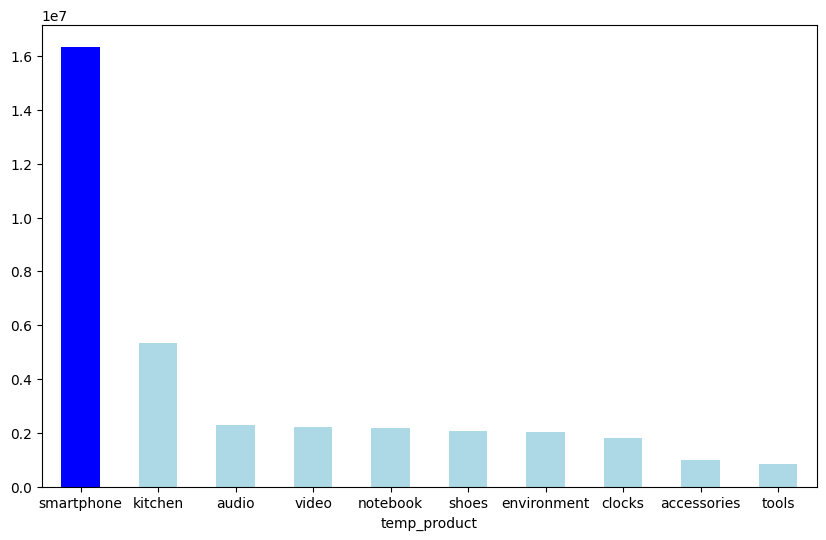

In [8]:
top10_product.plot(kind='bar', figsize=(10, 6), rot=0, color=['blue' if x == top10_product.max() else 'lightblue' for x in top10_product])